In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# fix macos n_job>1 bugs
import multiprocessing
multiprocessing.set_start_method('forkserver')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Load local python scripts.

In [2]:
#plot model evaluation metrics
from plotting import *

#data exploration functions
from data_exploration import *

#data pre-processing functions
from pre_processing import *

#classifiers and cross-validation
from classifiers import *

##  Dataset
Load data from disk and store as pandas dataframe.

In [3]:
#data sets
DATA_PATH = 'dataset/'
OUTPUT_PATH = None
FILE_NAME = 'city_search.json'

In [4]:
df = pd.read_json(DATA_PATH+FILE_NAME)
df['session_id'] = df.session_id.map(lambda x:x[0])
df['unix_timestamp'] = df.unix_timestamp.map(lambda x:x[0])
df['cities'] = df.cities.map(lambda x:x[0])
df['len'] = df.cities.map(lambda x:len(x.split(',')))
df['user_id'] = df.user.map(lambda x:x[0][0]['user_id'])
df['joining_date'] = df.user.map(lambda x:x[0][0]['joining_date'])
df['country'] = df.user.map(lambda x:x[0][0]['country'])
df = df.drop('user',axis=1)
df = df.replace({'' : 'UNK'})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   session_id      20022 non-null  object
 1   unix_timestamp  20022 non-null  int64 
 2   cities          20022 non-null  object
 3   len             20022 non-null  int64 
 4   user_id         20022 non-null  int64 
 5   joining_date    20022 non-null  object
 6   country         20022 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.1+ MB


Users have unique country.

In [6]:
non_missing = df[df.country!=''].user_id.to_list()
missing = df[df.country==''].user_id.to_list()
overlap = [m for m in missing if m in non_missing]
print(len(overlap))

0


Treat each country as a different feature, flatten data into one-hot vector.

In [7]:
all_city_names = set()
for row in df.cities.to_list():
    names = row.split(', ')
    for name in names:
        all_city_names.add(name)

all_city_names = sorted(list(all_city_names))
new_rows = np.zeros((df.shape[0],len(all_city_names)))

for i,row in enumerate(df.cities.to_list()):
    names = row.split(', ')
    for name in names:
        index = all_city_names.index(name)
        new_rows[i,index] = 1

df_one_hot = pd.DataFrame(new_rows, columns=all_city_names)
df_one_hot['user_id'] = df.user_id
df_one_hot['joining_date'] = df.joining_date
df_one_hot['country'] = df.country

In [8]:
df_one_hot

,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,...,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON,user_id,joining_date,country
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024,2015-03-22,UK
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2853,2015-03-28,DE
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10958,2015-03-06,UK
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7693,2015-03-12,IT
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7506,2015-02-28,UK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4360,2015-03-21,UNK
20018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2057,2015-03-22,IT
20019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1203,2015-02-28,IT
20020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3699,2015-03-24,ES


## Task 1

### Unsupervised(clustering)
Use K-mean clustering algorithm to represent each country as a cluster, assign the unknown country to the closest cluster.

#### Cluster by country
We assume that people from different country have different search behaviour and do the clustering.

In [9]:
from sklearn.cluster import KMeans

In [10]:
df_country = df_one_hot.groupby(['country']).sum().reset_index().drop('user_id',axis=1)
df_country = df_country.set_index(df_country.country).drop('country',axis=1)

In [11]:
df_country

,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,...,Toledo OH,Toronto ON,Tucson AZ,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
country,,,,,,,,,,,,,,,,,,,,,
DE,44.0,22.0,1.0,45.0,5.0,48.0,0.0,33.0,31.0,99.0,...,22.0,603.0,3.0,3.0,246.0,25.0,0.0,15.0,3.0,12.0
ES,27.0,8.0,3.0,15.0,1.0,21.0,1.0,16.0,10.0,66.0,...,11.0,327.0,0.0,0.0,148.0,20.0,4.0,8.0,1.0,6.0
FR,26.0,7.0,2.0,30.0,3.0,21.0,2.0,19.0,18.0,60.0,...,15.0,377.0,0.0,2.0,149.0,19.0,3.0,9.0,0.0,10.0
IT,26.0,17.0,1.0,19.0,3.0,30.0,0.0,15.0,15.0,45.0,...,6.0,294.0,3.0,2.0,134.0,26.0,3.0,5.0,0.0,5.0
UK,51.0,26.0,6.0,53.0,8.0,40.0,2.0,24.0,26.0,106.0,...,18.0,577.0,4.0,2.0,213.0,29.0,3.0,18.0,0.0,14.0
UNK,33.0,14.0,2.0,27.0,7.0,26.0,0.0,27.0,15.0,99.0,...,17.0,457.0,5.0,2.0,207.0,40.0,3.0,12.0,1.0,19.0
US,59.0,19.0,6.0,49.0,12.0,45.0,2.0,23.0,30.0,108.0,...,27.0,644.0,3.0,0.0,279.0,38.0,1.0,16.0,1.0,16.0


Decide the best numebr of clusters using elbow method.

In [12]:
def elbow_method(K,df_tar):
    sosd=[]
    for i in range(1,K+1):
        kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
        kmeans.fit(df_tar)
        sosd.append(kmeans.inertia_)

    plt.plot(range(1,K+1), sosd)
    plt.title('The Elbow Method')
    plt.xlabel('numebr of clusters')
    plt.ylabel('sum of squared distances')
    plt.show()

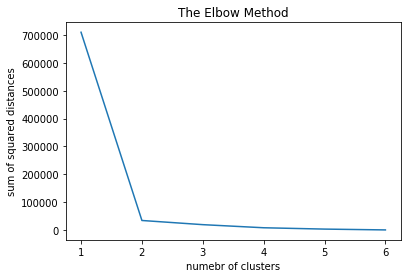

In [13]:
df_cluster = df_country.drop('UNK',axis=0)
df_miss = df_country.loc['UNK']
elbow_method(6,df_cluster)

Get cluster number and country name pair, predict unknown country by its cluster number.

In [14]:
kmeans = KMeans(n_clusters= 6, init='k-means++', random_state=0)
kmeans.fit(df_cluster)

country_cluster = dict()
for c in df_cluster.index:
    pred = kmeans.predict(df_country.loc[c].to_numpy().reshape(1,-1))[0]
    country_cluster[pred] = c

In [15]:
country_cluster

{4: 'DE', 1: 'ES', 3: 'FR', 5: 'IT', 0: 'UK', 2: 'US'}

In [16]:
country_cluster[kmeans.predict(df_miss.to_numpy().reshape(1,-1))[0]]

'FR'

Reduce dimension of data from 89 to 7 using PCA. Measuring cosine distance between each country confirms our previous assumption.

In [17]:
d7,_ = dimension_reduction(df_country,df_country,7)
pd.DataFrame(sklearn.metrics.pairwise.cosine_distances(d7))

Reduce dimension form 89 to 7


,0,1,2,3,4,5,6
0,0.000000,1.978528,1.981071,1.985980,0.040163,1.340332,0.037335
1,1.978528,0.000000,0.027851,0.018388,1.976730,0.625711,1.983692
2,1.981071,0.027851,0.000000,0.020620,1.959470,0.677522,1.974611
3,1.985980,0.018388,0.020620,0.000000,1.970648,0.658389,1.981920
4,0.040163,1.976730,1.959470,1.970648,0.000000,1.477452,0.039824
5,1.340332,0.625711,0.677522,0.658389,1.477452,0.000000,1.401183
6,0.037335,1.983692,1.974611,1.981920,0.039824,1.401183,0.000000


#### Cluster by user
Since each user belongs to only one country, we can assume users within the same country hava similar behaviours and assign missing country based on user clusters.

In [18]:
df_user = df_one_hot.groupby(['user_id','joining_date','country']).sum().reset_index().drop(['user_id','joining_date'],axis=1)
df_user = reorder_columns(df_user,0)

In [19]:
df_user

,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,...,Toronto ON,Tucson AZ,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON,country
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,DE
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UK
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UNK
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DE
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,DE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UK
5773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ES
5774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,US
5775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,US


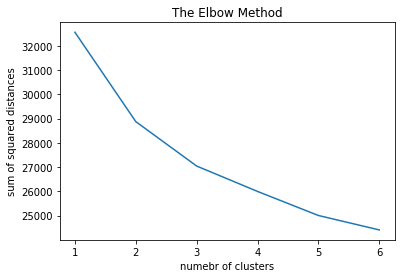

In [20]:
# other_country = df_user[df_user.country!='UNK'].drop('country',axis=1)
# no_country = df_user[df_user.country=='UNK'].drop('country',axis=1)
df_cluster = df_user.drop('country',axis=1)
df_miss = df_user[df_user.country=='UNK'].drop('country',axis=1)
elbow_method(6,df_cluster)

Vote user's cluster id with missing country, and predict their country based on other users in the same cluster.

In [21]:
kmeans = KMeans(n_clusters= 50, init='k-means++', random_state=0)
kmeans.fit(df_cluster)

user_cluster = dict()
for c in df_miss.index:
    pred = kmeans.predict(df_miss.loc[c].to_numpy().reshape(1,-1))[0]
    if pred not in user_cluster:
        user_cluster[pred] = 0
    user_cluster[pred] += 1

In [22]:
print(user_cluster)

{4: 34, 33: 18, 13: 41, 47: 9, 29: 10, 1: 14, 5: 16, 9: 9, 10: 16, 21: 24, 38: 19, 22: 30, 39: 19, 12: 18, 46: 28, 30: 14, 27: 33, 18: 17, 16: 19, 20: 15, 41: 25, 6: 16, 34: 29, 14: 12, 7: 27, 37: 29, 3: 5, 0: 11, 40: 8, 8: 13, 43: 6, 48: 17, 28: 16, 32: 18, 45: 11, 2: 18, 11: 16, 24: 12, 17: 5, 23: 11, 31: 5, 36: 5, 49: 9, 44: 9, 26: 13, 35: 15, 42: 8, 25: 7, 15: 9, 19: 4}


Country frequency of users in the same cluster with missing country users.

In [23]:
cluster_id = max(user_cluster, key=user_cluster.get)
print('vote cluster:',cluster_id)
candidate_country = dict()
for c in df_cluster.index:
    pred = kmeans.predict(df_cluster.loc[c].to_numpy().reshape(1,-1))[0]
    if pred == cluster_id:
        country = df_user.loc[c,'country']
        if country not in candidate_country:
            candidate_country[country] = 0
        candidate_country[country] += 1

vote cluster: 13


In [24]:
candidate_country

{'UNK': 41, 'DE': 48, 'IT': 25, 'FR': 21, 'UK': 47, 'ES': 26, 'US': 53}

In [25]:
country_name = max(candidate_country, key=candidate_country.get)
print('country:',country_name)

country: US


### Supervised(classification)
We can treat this task as classification problem of different countries, and predict missing country with search history as features.

In [26]:
# df_train = df_one_hot[df_one_hot.country!=''].drop(['user_id','joining_date'],axis=1)
# df_test = df_one_hot[df_one_hot.country==''].drop(['user_id','joining_date'],axis=1)
df_train = df_user[df_user.country!='UNK']
df_test = df_user[df_user.country=='UNK']

In [27]:
df_train

,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,...,Toronto ON,Tucson AZ,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON,country
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,DE
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UK
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DE
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,DE
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UK
5773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ES
5774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,US
5775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,US


Retrieve class(country) names after encoding.

In [28]:
known_country_name = df_train.country.value_counts().index.to_list()
df_train = encode_labels(df_train, df_train)[0]
known_country_index = df_train.country.value_counts().index.to_list()

class_names = [None]*len(known_country_name)
for i,n in zip(known_country_index,known_country_name):
    class_names[i] = n

Encoding X features...


In [29]:
class_names

['DE', 'ES', 'FR', 'IT', 'UK', 'US']

Show correlations of all features.

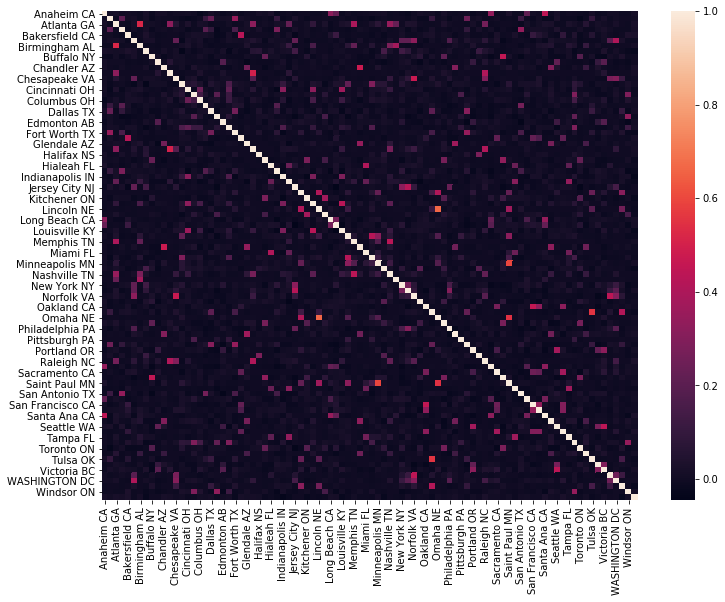

In [30]:
show_correlation(df_train)

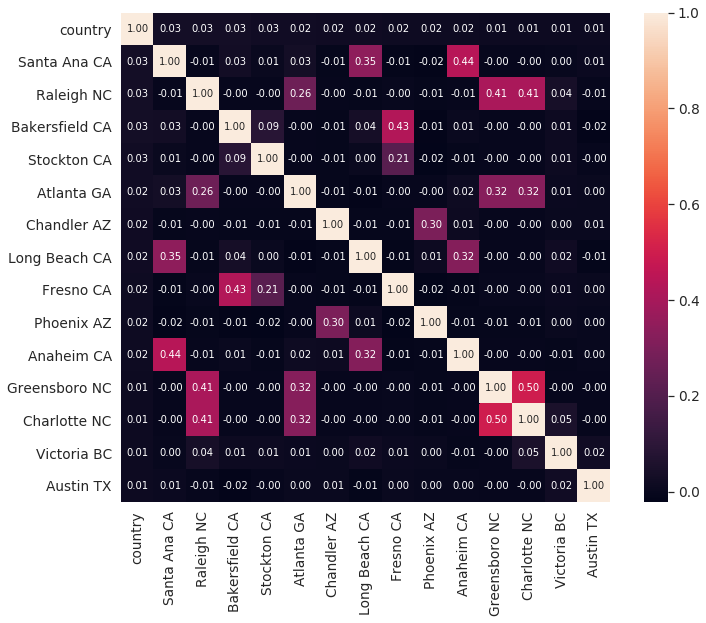

In [31]:
cols = show_top_related(df_train, 'country', k=15)

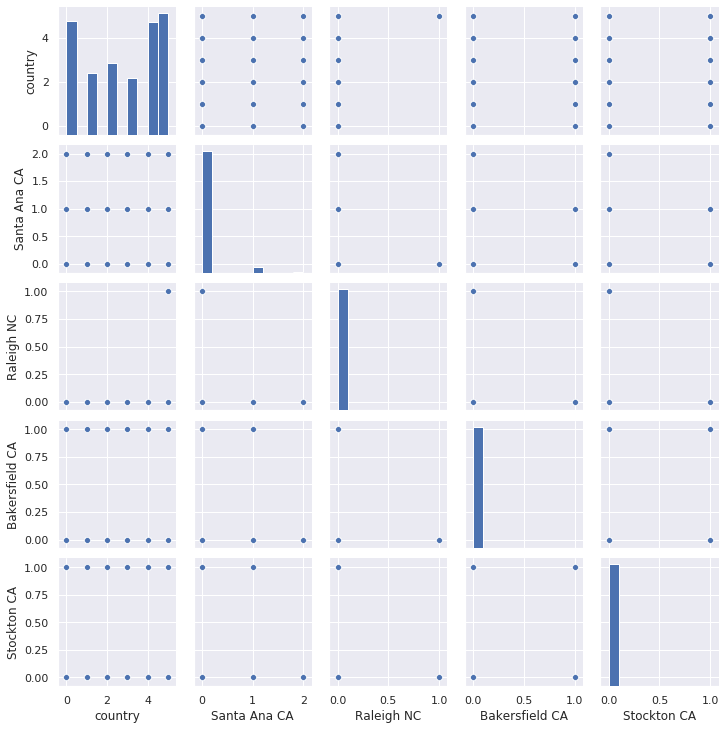

In [32]:
show_pair_plot(df_train[cols[:5]])

In [33]:
"""
Pipeline class takes pre-processing functions and their parameters,
process the data before making predictions, store processed data and best models afterwards.
See pre_processing.py, regressors.py and plotting.py for more details.
"""
class Pipeline:
    #take a dictionary with function as key and functions' parameters as value
    def __init__(self, transformers):
        self.transformers = transformers
        self.estimators = None
        self.estimators_times = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
    
    #preprocess dataset with given functions and store in the model
    #see pre_processing.py
    def fit(self, x_train, y_train, x_test, y_test):
        x_train, x_test = x_train, x_test
        for trans in self.transformers:
            param = self.transformers[trans]
            if param == None:
                x_train, x_test = trans(x_train, x_test)
            elif type(param) is list and len(param)==2:
                x_train, x_test = trans(x_train, x_test, param[0], param[1])
            else:
                x_train, x_test = trans(x_train, x_test, param)
        self.X_train = x_train
        self.X_test = x_test
        self.y_train = y_train
        self.y_test = y_test
    
    #make prediction and evaluate with defualt metrics.
    #see regressors.py and plotting.py
    def predict(self, estimator='all'):
        assert self.X_train is not None
        if estimator == 'all':
            all_clfs, clf_names, clf_times = run_all_clfs(self.X_train, self.y_train, self.X_test, self.y_test)
            roc, pr = evaluate_classifiers(self.X_test, self.y_test, all_clfs, clf_names, FILE_NAME, OUTPUT_PATH)
        elif estimator == 'lr':
            all_clfs, clf_names, clf_times = run_lr_clf(self.X_train, self.y_train, self.X_test, self.y_test)
            roc, pr = evaluate_classifiers(self.X_test, self.y_test, all_clfs, clf_names, FILE_NAME, OUTPUT_PATH)            
        self.estimators = all_clfs
        self.estimators_times = clf_times


In [34]:
X = df_train.iloc[:,:-1]
y = df_train.iloc[:,-1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
print(X_train.shape,X_val.shape)

(3489, 89) (1496, 89)


Run logistic regression on training set and evaluate with ROC PR curves.

Encoding X features...
Standardized data with StandardScaler
Training LogisticRegression ...


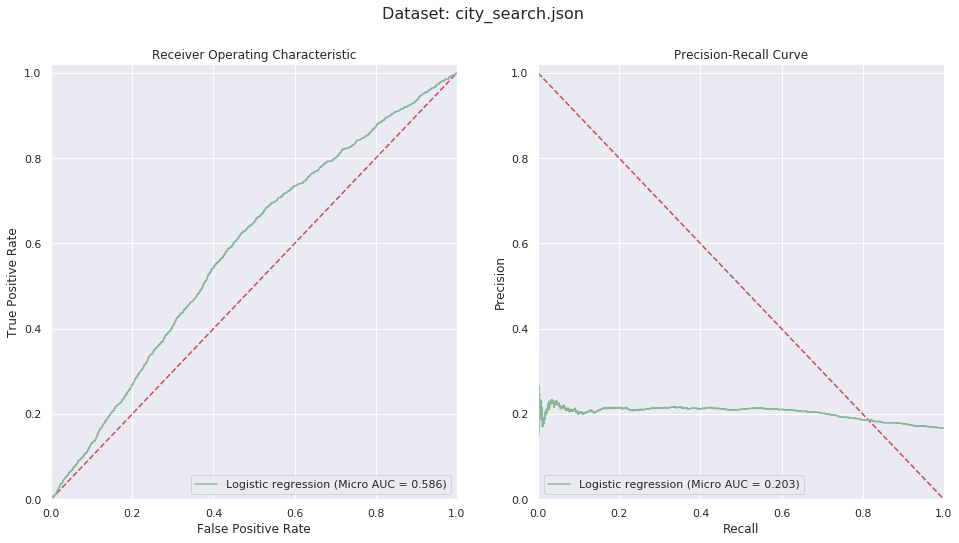

Training Set: X_train (3489, 89), y_train (3489,)
Val Set: X_test (1496, 89), y_test (1496,)
CPU times: user 3.8 s, sys: 356 ms, total: 4.16 s
Wall time: 14.8 s


In [35]:
%%time
model = Pipeline({encode_labels:preprocessing.LabelEncoder(),
                  standardize_data:preprocessing.StandardScaler(),
                 })
model.fit(X_train, y_train, X_val, y_val)
model.predict(estimator='lr')
print('Training Set: X_train %s, y_train %s'%(model.X_train.shape,model.y_train.shape))
print('Val Set: X_test %s, y_test %s'%(model.X_test.shape,model.y_test.shape))

#### PCA
Reduce dimension with PCA to speed up. Run different classifier and choose the best by cross_validation.

Encoding X features...
Standardized data with StandardScaler
Reduce dimension form 89 to 6
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


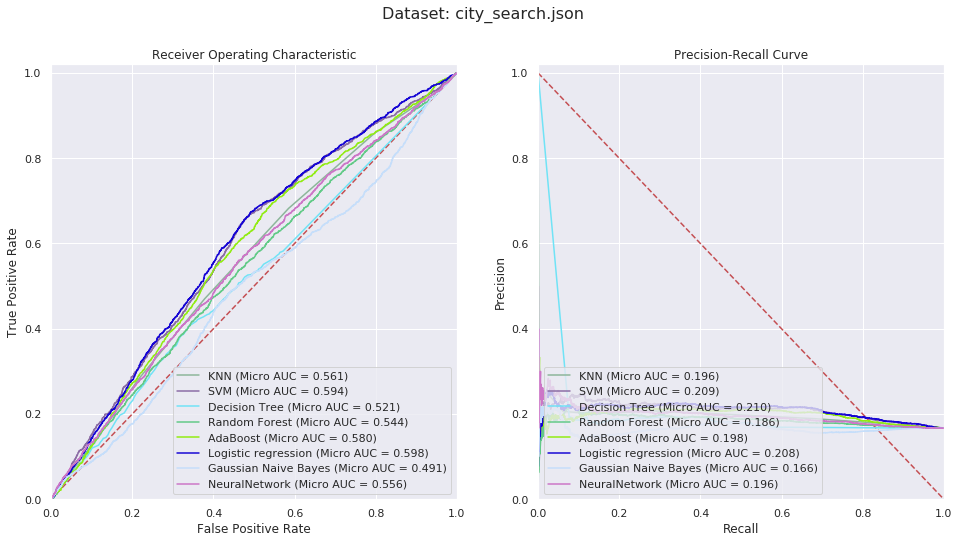

Training Set: X_train (3489, 89), y_train (3489,)
Val Set: X_test (1496, 89), y_test (1496,)
CPU times: user 1min 52s, sys: 2.11 s, total: 1min 54s
Wall time: 1min 16s


In [36]:
%%time
model2 = Pipeline({encode_labels:preprocessing.LabelEncoder(),
                   standardize_data:preprocessing.StandardScaler(),
                   dimension_reduction:6,
                 })
model2.fit(X_train, y_train, X_val, y_val)
model2.predict()
print('Training Set: X_train %s, y_train %s'%(model.X_train.shape,model.y_train.shape))
print('Val Set: X_test %s, y_test %s'%(model.X_test.shape,model.y_test.shape))

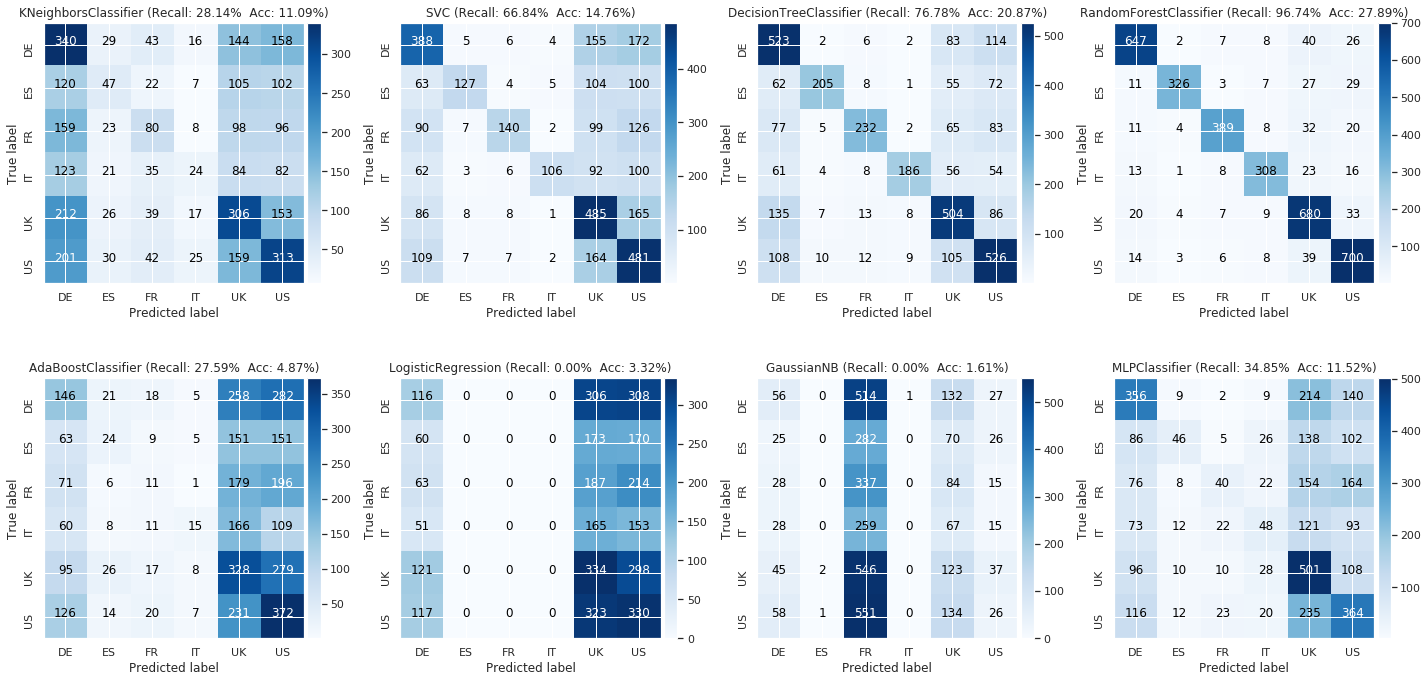

In [37]:
plt.figure(figsize=(20,10))
for i,e in enumerate(model2.estimators):
    plt.subplot(2,4,i+1)
    name = str(e).split('(')[0]
    plot_confusion_matrix(e, model2.X_train, model2.y_train, classes=class_names, cmap=plt.cm.Blues, normalize=None, title=name)

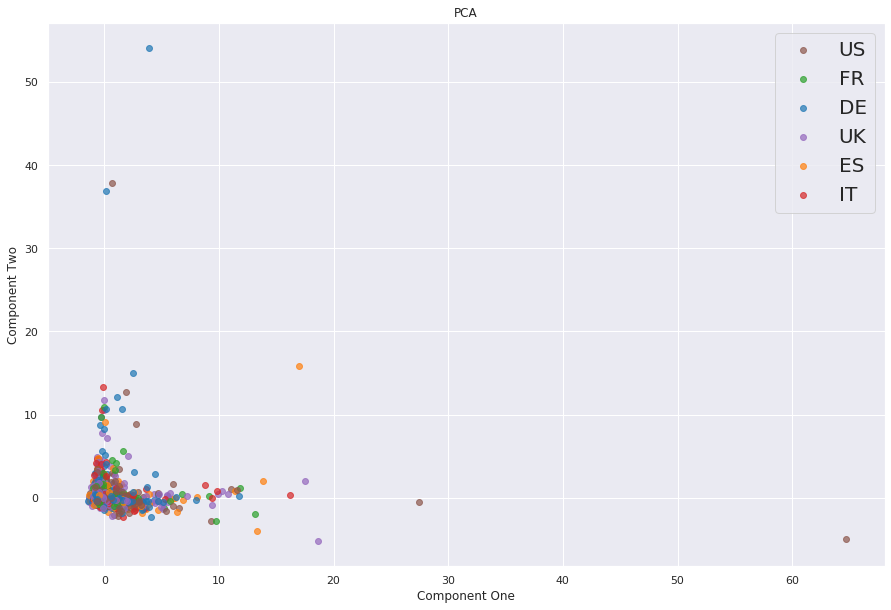

In [38]:
plot_embedding(model2.X_train, model2.y_train, class_names, 'PCA')

#### t-SNE
Further reduce dimension by t-SNE and plot embedding.

In [39]:
X_embedded = TSNE(n_components=2).fit_transform(model2.X_train)

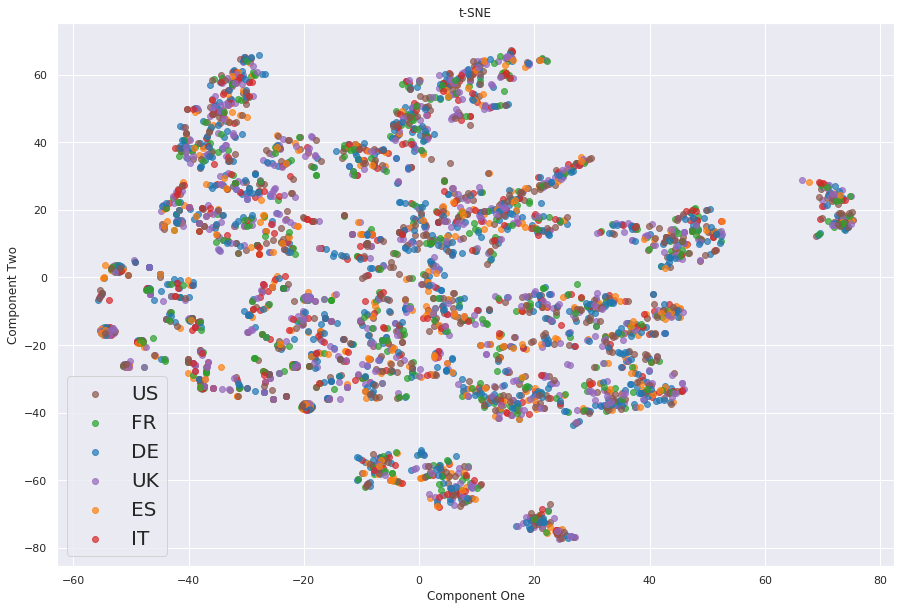

In [40]:
plot_embedding(X_embedded, model2.y_train, class_names, 't-SNE')

Prediction distribution of missing country, choose the majority.

In [41]:
pred_country = []
X_unknown = df_test.iloc[:,:-1]
model.fit(X_unknown,X_unknown,X_unknown,X_unknown)
y_pred = model.estimators[0].predict(model.X_train)

Encoding X features...
Standardized data with StandardScaler


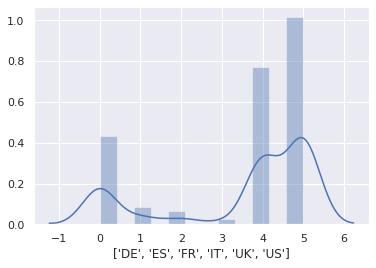

In [42]:
sns.distplot(y_pred,axlabel=class_names);

In [43]:
pred_country = dict()
for p in y_pred:
    country = class_names[p]
    if country not in pred_country:
        pred_country[country] = 0
    pred_country[country] += 1

In [44]:
pred_country

{'UK': 255, 'US': 335, 'DE': 143, 'FR': 22, 'ES': 28, 'IT': 9}

In [45]:
country_name = max(pred_country, key=pred_country.get)
print('country:',country_name)

country: US


### Semi-Supervised (autoencoder)
Find hidden representation of features by autoencoder, than do classfication with hidden data.

In [46]:
import torch
from torch import nn
from torch.nn import Linear, ReLU, Sequential
import torch.optim as optim

Retrieve all country names.

In [47]:
df_encode = encode_labels(df_user, df_user)[0]
all_country_name = df_user.country.value_counts().index.to_list()
all_country_index = df_encode.country.value_counts().index.to_list()

all_class_names = [None]*len(all_country_name)
for i,n in zip(all_country_index,all_country_name):
    all_class_names[i] = n

Encoding X features...


In [48]:
X = df_encode.iloc[:,:-1]
y = df_encode.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

pipeline = Pipeline({encode_labels:preprocessing.LabelEncoder(),
                   standardize_data:preprocessing.StandardScaler(),
                 })
pipeline.fit(X_train, y_train, X_test, y_test)

Encoding X features...
Standardized data with StandardScaler


In [49]:
pipeline.X_train.shape, pipeline.X_test.shape, 

((4043, 89), (1734, 89))

Create different training sets for different classes(country).

In [50]:
total_class = len(all_country_name)

all_x_train = []
all_x_test = []
all_x_torch = []
for i in range(total_class):
    all_x_train.append(pipeline.X_train[pipeline.y_train.values == i])
    all_x_test.append(pipeline.X_test[pipeline.y_test.values == i])
    all_x_torch.append(torch.tensor(pipeline.X_train[pipeline.y_train.values == i].values.astype(np.float32)))

In [51]:
len(all_x_train),len(all_x_test),len(all_x_torch)

(7, 7, 7)

#### Build autoencoder
Build 5 layers neural network as autoencoder.

In [52]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(X_torch.shape[1], 500),
            nn.ReLU(True),
            nn.Linear(500, 250),
            nn.ReLU(True),
            nn.Linear(250, 250),
            nn.ReLU(True), 
        )    
        self.decoder = nn.Sequential(
            nn.Linear(250, 500),
            nn.ReLU(True), 
            nn.Linear(500, X_torch.shape[1]),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### Train autoencoder
Train different autoencoder for different classes.

In [53]:
all_autoencoder = []
for X_torch in all_x_torch:
    torch.manual_seed(0)
    autoencoder = Autoencoder()

    loss = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-5)

    batch_size = 128
    num_epoch = 1000

    for epoch in range(num_epoch):
        
        # Make an entire pass (an 'epoch') over the training data in batch_size chunks
        for i in range(0, len(X_torch), batch_size):
            X = X_torch[i:i+batch_size]  
            pred = autoencoder(X)
            l = loss(pred, X)                 

            autoencoder.zero_grad()                   
            l.backward()                       
            optimizer.step()   

        if (epoch+1)%499==1:    
            print("Epoch %d final minibatch had loss %.4f" % (epoch+1, l.item()))
    all_autoencoder.append(autoencoder)

Epoch 1 final minibatch had loss 1.1079
Epoch 500 final minibatch had loss 0.0053
Epoch 999 final minibatch had loss 0.0043
Epoch 1 final minibatch had loss 1.2098
Epoch 500 final minibatch had loss 0.0033
Epoch 999 final minibatch had loss 0.0019
Epoch 1 final minibatch had loss 0.6381
Epoch 500 final minibatch had loss 0.0013
Epoch 999 final minibatch had loss 0.0022
Epoch 1 final minibatch had loss 0.8243
Epoch 500 final minibatch had loss 0.0016
Epoch 999 final minibatch had loss 0.0015
Epoch 1 final minibatch had loss 0.9762
Epoch 500 final minibatch had loss 0.0053
Epoch 999 final minibatch had loss 0.0024
Epoch 1 final minibatch had loss 1.1610
Epoch 500 final minibatch had loss 0.0056
Epoch 999 final minibatch had loss 0.0062
Epoch 1 final minibatch had loss 1.0590
Epoch 500 final minibatch had loss 0.0076
Epoch 999 final minibatch had loss 0.0134


#### Get hidden representation
Get hidden representation by applying encoder on data, concatenate all classes back to original rows.

In [54]:
def get_all_hidden(all_autoencoder, all_x_class):
    all_x_hidden = []
    all_y_hidden = []
    
    for i,x_class_i in enumerate(all_x_class):
        x_hidden = all_autoencoder[i].encoder(torch.tensor(x_class_i.values.astype(np.float32))).detach().numpy()
        all_x_hidden.append(pd.DataFrame(x_hidden))
        y_hidden = pd.Series(np.full(x_class_i.shape[0],i))
        all_y_hidden.append(y_hidden)
    
    X_hidden = pd.concat(all_x_hidden,axis=0)
    y_hidden = pd.concat(all_y_hidden,axis=0).astype('int64')
    return X_hidden, y_hidden

In [55]:
X_hidden_train, y_hidden_train = get_all_hidden(all_autoencoder, all_x_train)
X_hidden_test, y_hidden_test = get_all_hidden(all_autoencoder, all_x_test)

Clustering by hidden states.

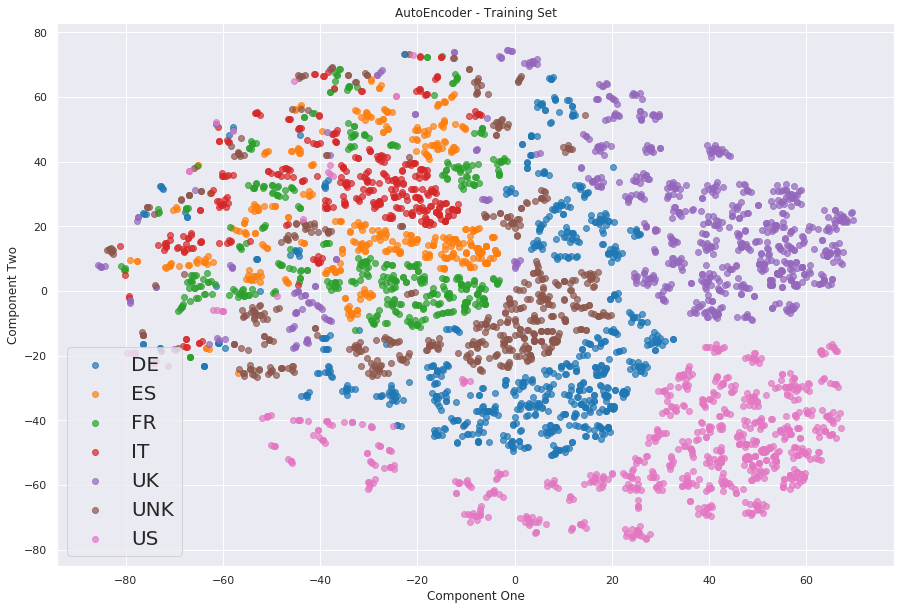

In [56]:
X_embedded = TSNE(n_components=2, random_state=0).fit_transform(X_hidden_train)
plot_embedding(X_embedded, y_hidden_train, all_class_names, 'AutoEncoder - Training Set')

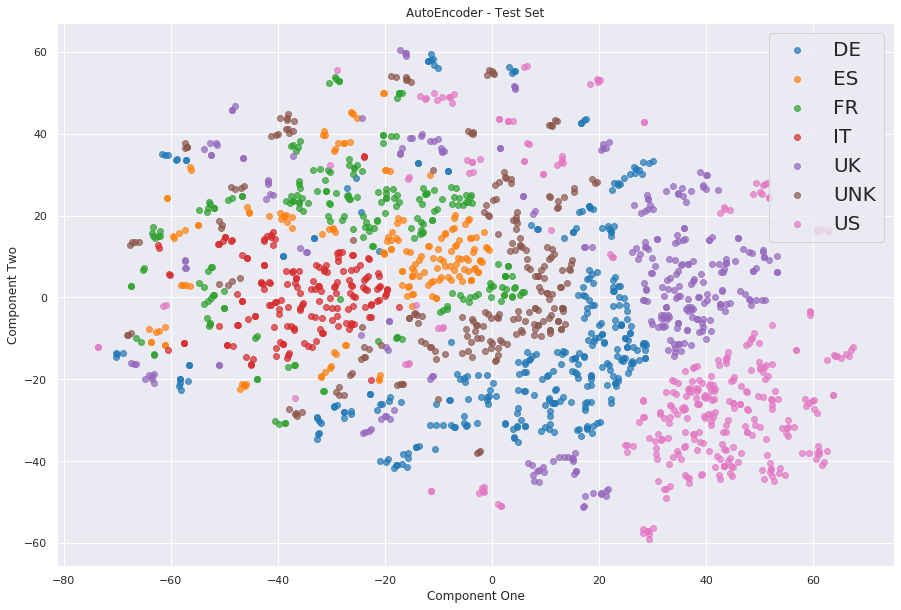

In [57]:
X_embedded = TSNE(n_components=2, random_state=0).fit_transform(X_hidden_test)
plot_embedding(X_embedded, y_hidden_test, all_class_names,'AutoEncoder - Test Set')

#### Classification on hidden representation
Different classes are much easier to separate now, classification could be solve by a simple classifier.

Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


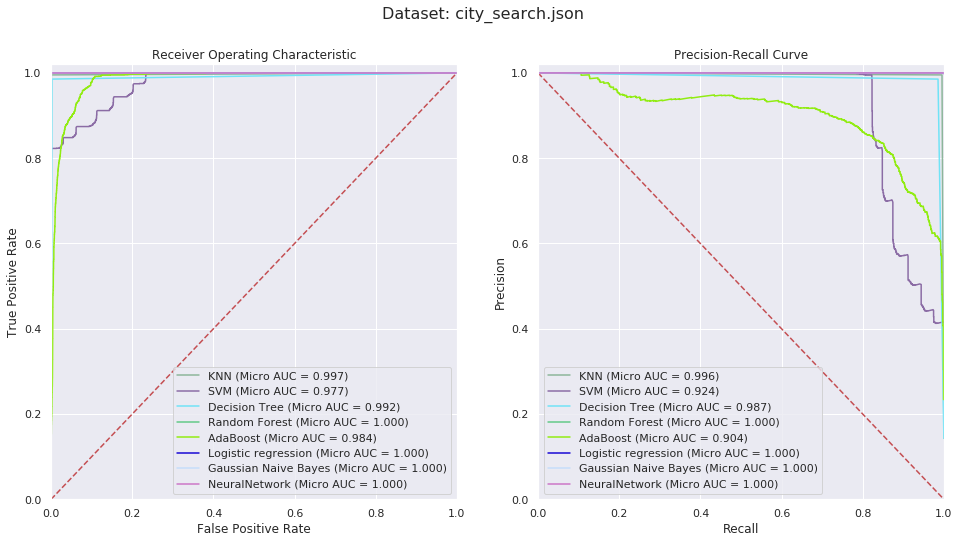

Training Set: X_train (4043, 250), y_train (4043,)
Test Set: X_test (1734, 250), y_test (1734,)
CPU times: user 2min 18s, sys: 908 ms, total: 2min 18s
Wall time: 4min 38s


In [58]:
%%time
simple = Pipeline({})
simple.fit(X_hidden_train, y_hidden_train, X_hidden_test, y_hidden_test)
simple.predict(estimator='all')
print('Training Set: X_train %s, y_train %s'%(simple.X_train.shape, simple.y_train.shape))
print('Test Set: X_test %s, y_test %s'%(simple.X_test.shape, simple.y_test.shape))

Very good performance without sacrifice the recall, training is also much faster.

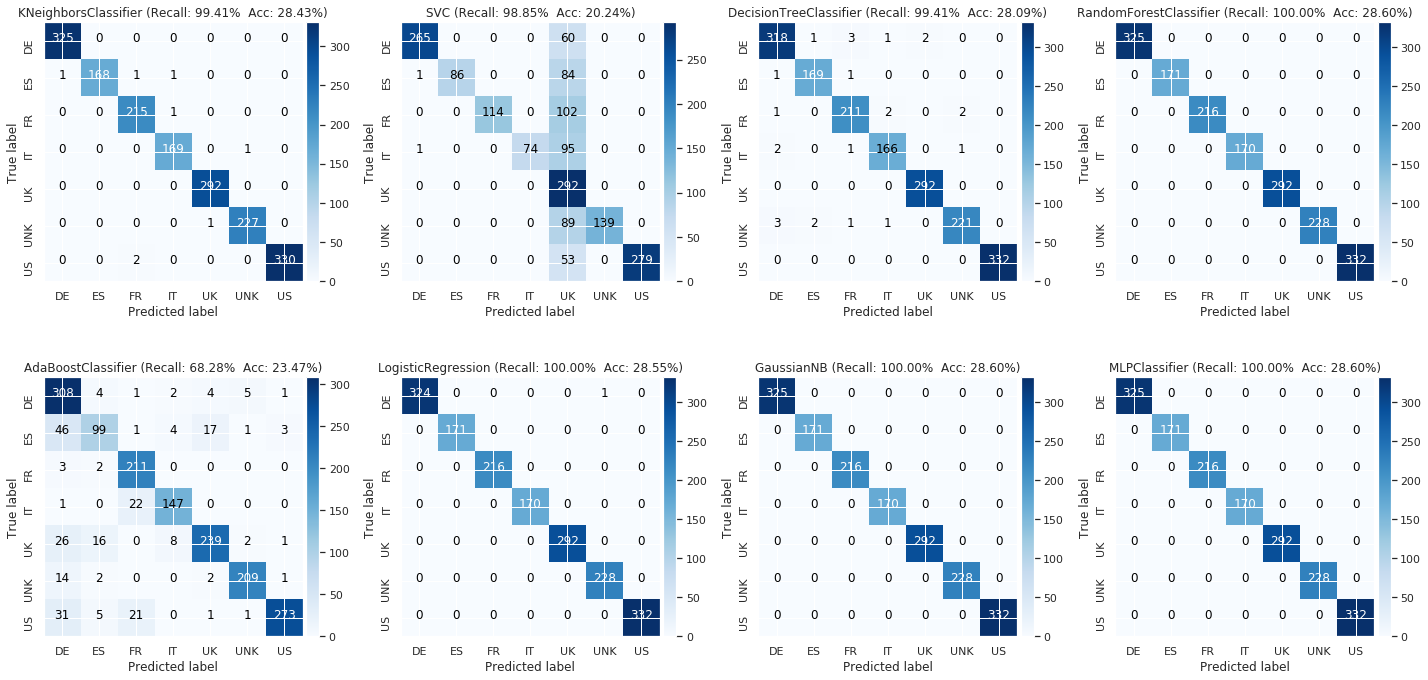

In [60]:
plt.figure(figsize=(20,10))
for i,e in enumerate(simple.estimators):
    plt.subplot(2,4,i+1)
    name = str(e).split('(')[0]
    plot_confusion_matrix(e, simple.X_test, simple.y_test, classes=all_class_names, cmap=plt.cm.Blues, normalize=None, title=name)